# Objective
Build a Python script that generates vector diagrams to visualize the 
progressive movement from one pose to the next using pose data.

# Learning Objectives  
- Use pandas to clean and transform pose data into DataFrames for easier manipulation.
- Apply indexing and selection techniques to enhance DataFrame readability and performance.
- Use pandas methods to identify and remove incomplete or missing data rows.
- Perform feature engineering to convert raw pose keypoints into a usable vector format.
- Use slicing techniques to manipulate pose data for comparison and visualization.
- Utilize Matplotlib to generate custom diagrams showing movement between poses.

# Data
Our data comes from https://openposes.com/, a human pose detection library 
that works by identifying multiple "keypoints" on the human body and 
generating a consistent skeletal structure to represent the person.

We've downloaded pose data in JSON format, located in the `poses` directory. 
Each JSON file contains an array of keypoints, reference coordinates for 
different parts of the body.

Related images are located in the `pose_images` directory.

# Installation
I was using a Python file instead of a Jupyter notebook, so I wasn’t sure 
if a virtual environment is needed to run the content I’ve added. 
I included the instructions here—feel free to remove them if unnecessary.

# Virtual Environment
In Python 3, we can install packages to add tools that make development easier.
It’s recommended to create a virtual environment for each project to keep 
dependencies isolated. This allows you to run multiple projects on the same 
system without conflicts and makes it easy to share your exact development 
setup with others—ensuring consistency and reducing bugs overall.

In your terminal, run:
`python3 -m venv .venv`
This will create a `.venv` folder for your virtual environment.

To activate the environment, run:
`source .venv/bin/activate

# Installing Packages
In terminal, run: 
`pip install pandas`
`pip install matplotlib`

# Imports
We will be using a combination of built-in Python modules and external  
libraries (installed via pip) to support our script.

# Built-in Python Modules
- copy: Allows us to make shallow or deep copies of objects. Useful when we want to duplicate pose data without altering the original.
- json: Provides tools for reading and writing JSON. Our pose data is stored in JSON format, so we'll use this to parse it into Python objects.
- os: Enables interaction with the operating system. We're using:
- listdir: to get all files in a directory.
- path: to manage file paths in a system-independent way.


# External Libraries (Installed via pip)
- pandas: For data cleaning and transformation using DataFrames.
- matplotlib: For generating vector diagrams based on movement data.

In [1]:
from pandas import DataFrame
import pandas as pd
import copy, json, os
from os import listdir, path
import matplotlib.pyplot as plt

In [2]:
# Ensure the 'diagrams' directory exists
if not os.path.exists("diagrams"):
    os.makedirs("diagrams")

# Keypoint Index Mapping
Our keypoint coordinates are organized by index, with each column representing 
a specific coordinate (e.g., 00x, 00y). However, each index corresponds to a 
particular body location.

The list below maps each index to its body location using the COCO Pose Output 
Format. This may be helpful later for debugging or visual interpretation.

In [3]:
coord_to_name = ["head",
                 "hips",
                 "left_shoulder",
                 "left_elbow",
                 "left_hand",
                 "right_shoulder",
                 "right_elbow",
                 "right_hand",
                 "left_hip",
                 "left_knee",
                 "left_foot",
                 "right_hip",
                 "right_knee",
                 "right_foot",
                 "left_eye",
                 "right_eye",
                 "left_ear",
                 "right_ear"]

# Step 1: Load and Examine Pose Data
The first step is to load and organize our data from the source directory.
We'll use a few helper functions to process the raw JSON pose data into 
structured format that we can analyze and visualize.

index_poses:
- Imports the pose JSON filenames from the `poses` directory and organizes them into a sorted list.

In [4]:
def index_poses(path="poses"):
    json_list = listdir(path)
    json_list.sort()        # Needed to prevent the JSONs from being in a seemingly random order
    return json_list

json_list = index_poses()

get_pose_names:
- Extracts the name of each pose (filename without extension) from the JSON list. These names will be used later to label our diagrams.

In [5]:
def get_pose_names(json_list):
    return [path.splitext(fname)[0] for fname in json_list]

pose_names = get_pose_names(json_list)
print(pose_names)

['dance_01', 'dance_02', 'dance_03', 'dance_04', 'dance_05', 'flexing_01', 'flexing_02', 'flexing_03', 'jumping_01', 'jumping_02', 'jumping_03', 'jumping_04', 'jumping_05', 'laying_02', 'laying_03', 'laying_05', 'sitting_01', 'sitting_02', 'sitting_03', 'sitting_05', 'sitting_06', 'sitting_11', 'sitting_14', 'sitting_15', 'sitting_16', 'standing_01', 'standing_02', 'standing_03', 'standing_04', 'standing_05', 'standing_06', 'standing_07', 'standing_08', 'standing_09', 'standing_10', 'standing_13', 'standing_14', 'standing_15', 'standing_16', 'standing_17', 'standing_18', 'standing_19', 'standing_20', 'standing_21', 'tpose_01', 'tpose_02']


read_all_poses:
- Extracts all keypoints from each JSON file in the list.
- Loops through and loads each file, pulling out keypoint data.
- Performs light feature engineering by removing Z-axis values (which are constant and unused in 2D analysis), helping reduce bloat and improve performance.

In [6]:
def read_all_poses(json_list,path="poses"):
    pose_list = []
    for i in range(len(json_list)):
        item = path + "/" + json_list[i]
        with open(item) as file:
            data = json.load(file)
            points_list = list(data[0]["people"][0]["pose_keypoints_2d"])   # Hardcoded to fit the JSON scheme
            unneeded_3d_coord = 1.0   # the JSONs provide z-axis data, which we don't need, and it's all 1.0
            points_list = [i for i in points_list if i != unneeded_3d_coord]
            pose_list.append(points_list)
    return pose_list

pose_list = read_all_poses(json_list)

# Convert to DataFrame
We'll transform our cleaned keypoint data into a structured pandas DataFrame 
with appropriate coordinate labels for easier computation and manipulation.

generate_column_labels:
- Generates x and y coordinate labels (e.g., 00x, 00y, 01x, 01y, etc.) for all keypoints to be used as DataFrame column headers.

In [7]:
def generate_column_labels(coords=18):
    labels = []
    for i in range(coords):
        formatted_number = f"{i:02d}"           # Formats to 2 digit string representation of int, which will only work well to 99 points
        labels.append(formatted_number + "x")
        labels.append(formatted_number + "y")
    return labels

labels = generate_column_labels()

prep_dataframe:
- Initializes and returns an empty DataFrame with the appropriate coordinate labels as columns.

In [8]:
# Create DataFrame with proper coordinate labels
def prep_dataframe(labels):
    return DataFrame(columns=labels)

df = prep_dataframe(labels)

store_pose:
- Takes a single pose and appends it as a new row in the DataFrame.
- Uses .loc to index the next available row position and safely inserts the pose data using a shallow copy to avoid data loss.

In [9]:
def store_pose(pose, labels, df):
    if len(pose) != len(labels):
        print("Error: Size mismatch between coordinates list and labels")
        return df
    temp_points = copy.copy(pose)   # Use a copy so that we don't potentially lose poses if we reuse the variable
    df.loc[len(df)] = temp_points   # Append to df. No need to return; it's an in-place edit

store_all_poses:
- Loops through the full list of poses and calls `store_pose` to convert and append each pose to the DataFrame.

In [10]:
def store_all_poses(pose_list, labels, df):
    for pose in pose_list:
        store_pose(pose, labels, df)

store_all_poses(pose_list, labels, df)

# Step 2: Clean and Filter Incomplete Rows
One of pandas' greatest strengths is its ability to clean and normalize data.
In this step, we'll remove any incomplete or missing pose data to improve the
accuracy and consistency of our results.

 print_empties:
- This function displays any rows in the DataFrame that contain missing values.
- It helps confirm what data will be removed, and gives us the option to later transform or impute missing values if we decide they’re important.

In [11]:
def print_empties(df):
    df_nan = df[df.isna().any(axis=1)] 
    if df_nan.empty:
        print("No incomplete rows")
    else:
        print(df_nan)

print_empties(df)

No incomplete rows


df.dropna(inplace=True):
- A simple one-liner provided by pandas that removes all rows with any missing values from the DataFrame.

In [12]:
df.dropna(inplace=True)

# Step 3: Create Derived Features — Vectors
To graph the movement from one pose to the next, we need to calculate the 
vector between two poses. This is another form of feature engineering where 
we use selection, indexing, and slicing to transform raw pose coordinates 
into vector representations.

coords_to_vectors:
- Starts by creating a new DataFrame called `vects` to store the movement vectors.
- Loops through the original pose DataFrame (`df`), using `.iloc` to slice out two consecutive rows (pose1 and pose2).
- Converts each pose to a list of values, then loops through each coordinate to calculate the difference between pose2 and pose1, fiving us our vector
- Appends the movement list as a new row in `vects`.
- Finally, calls `.reset_index()` to ensure a clean, sequential index.

Step 4: Creating Diagrams with Matplot
It’s time to visualize our pose data as diagrams!
In this step, we use Matplotlib to generate directional movement graphs
from each pose to the next.

generate_vector_graph:
- Takes a starting pose, its corresponding movement vector, and two pose names.
- Uses `plt.figure()` to define the diagram’s size.
- Sets a title using the pose names to indicate which movement is being shown.
- Loops through the pose coordinates (x, y) and matches each with its movement (dx, dy).
- Uses `plt.quiver()` to draw arrows representing movement direction and magnitude:
  - `x, y`: starting point
  - `dx, dy`: direction and length of movement
  - `angles='xy'`, `scale_units='xy'`, and `scale=1`: ensure vector scaling is consistent with the coordinate space.
  - `color='blue'`: sets the arrow color.
- Adds x and y labels using `plt.xlabel()` and `plt.ylabel()`.
- Turns on gridlines with `plt.grid()` to improve readability.
- Calls `set_aspect('equal')` to keep the grid square and movement vectors proportional.
- Uses `invert_yaxis()` to match image coordinate systems like OpenPose, where (0,0) is the top-left — flipping the plot vertically for a more accurate visual comparison.
- Saves each diagram as a PNG file to the `diagrams/` directory using `plt.savefig()`.


In [13]:
def coords_to_vectors(df):
    labels = df.columns
    vects = DataFrame(columns=labels)
    for i in range(0,len(df)-1):            # Outer loop to handle the rows
        pose1 = df.iloc[i].values.tolist()
        pose2 = df.iloc[i+1].values.tolist()
        movement = []
        for j in range(len(pose1)):
            movement.append(pose2[j] - pose1[j])
        vects.loc[len(df)] = movement
        vects.reset_index(drop=True, inplace=True)
    return vects

vectors = coords_to_vectors(df)

loop_through_poses:
- Takes the original pose DataFrame (`df`), the movement vectors (`vectors`), and the list of pose names.
- Iterates over each movement vector and calls `generate_vector_graph()` to create a visual diagram for every pair of poses.

In [14]:
def generate_vector_graph(pose, movement, pose_name1, pose_name2):
    plt.figure(figsize=(6, 6))
    plt.title(f"Movement Vectors: {pose_name1} → {pose_name2}")

    for i in range(0, len(pose), 2):  # every (x, y) pair
        x = pose[i]
        y = pose[i+1]
        dx = movement[i]
        dy = movement[i+1]
    
        plt.quiver(x, y, dx, dy, angles='xy', scale_units='xy', scale=1, color='blue')

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)
    plt.gca().set_aspect('equal')
    plt.gca().invert_yaxis()
    plt.savefig(f"diagrams/pose_{pose_name1}_to_{pose_name2}.png")

/var/folders/gq/k4nf9j812j53tksmbwh1rz0r0000gn/T/ipykernel_8226/2013120280.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 6))


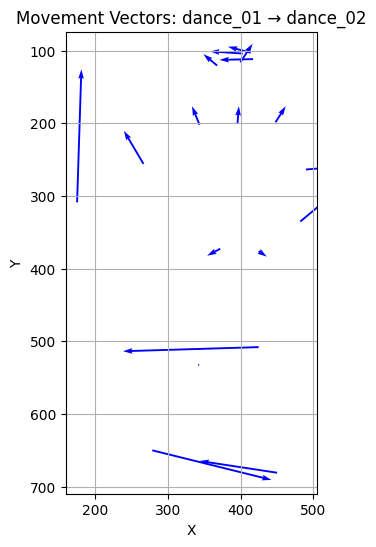

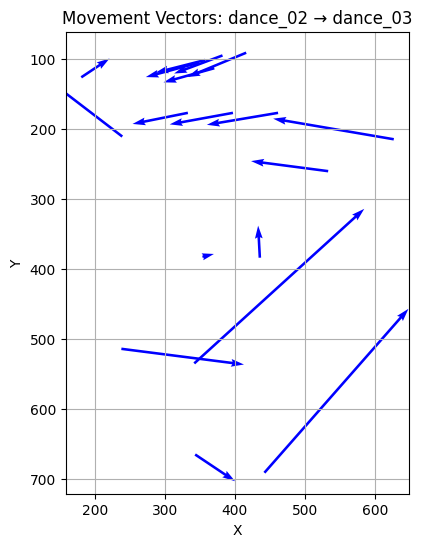

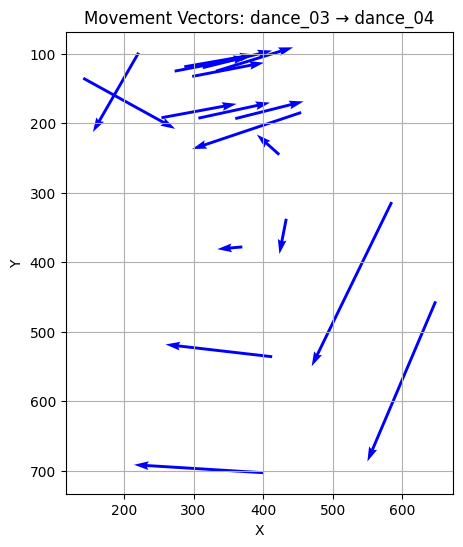

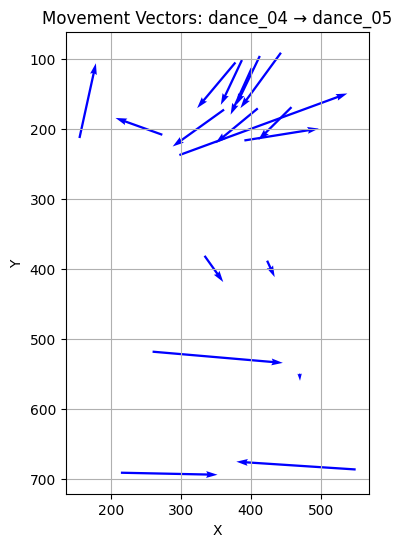

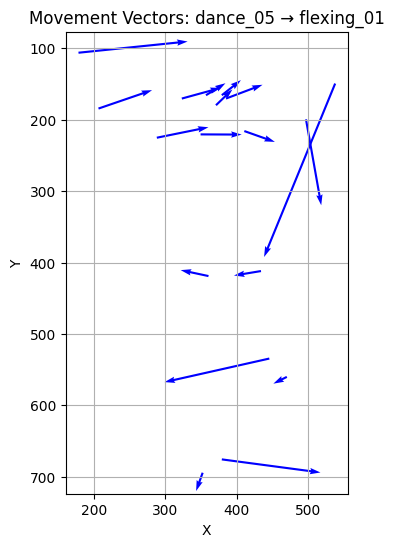

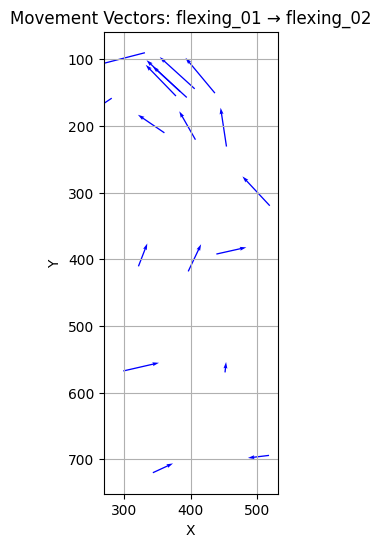

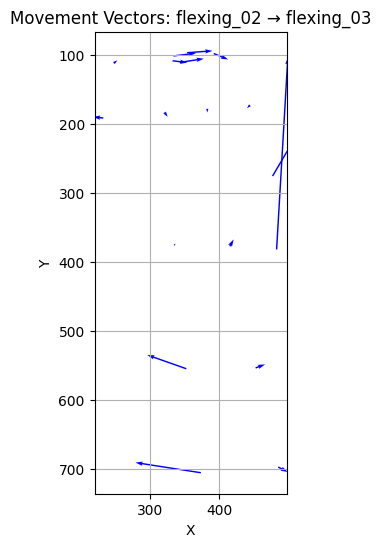

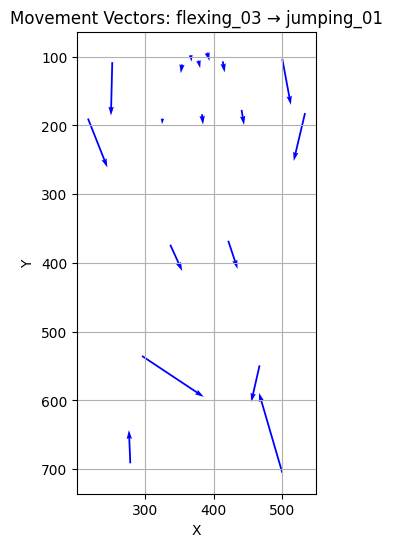

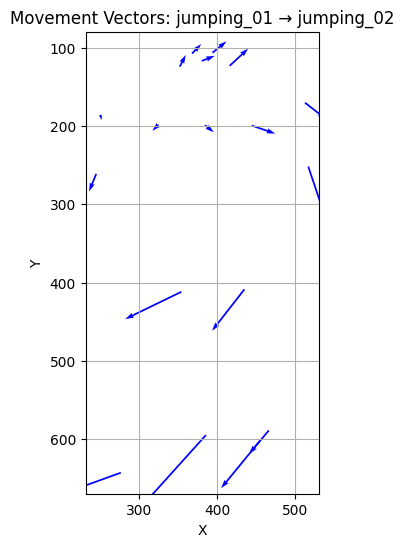

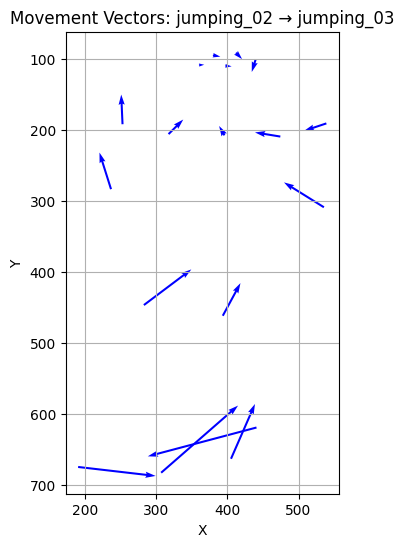

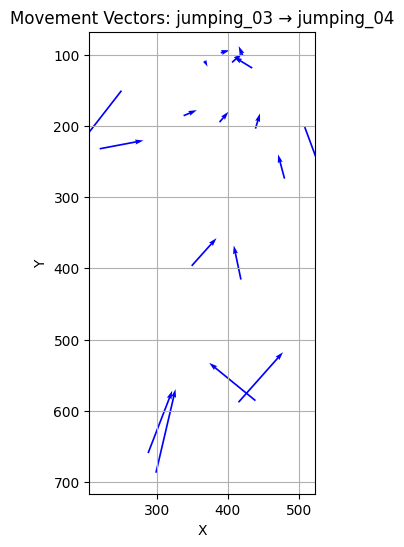

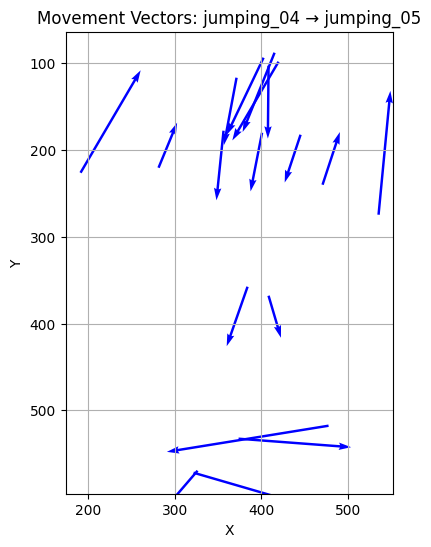

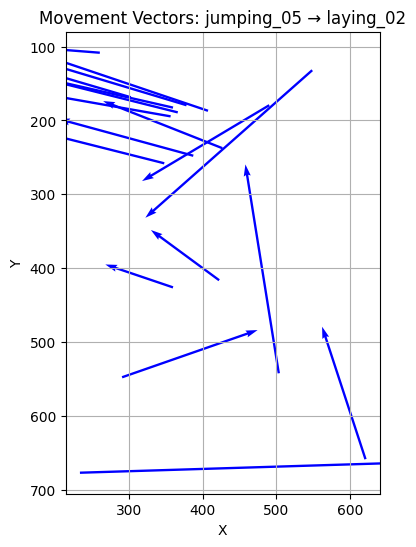

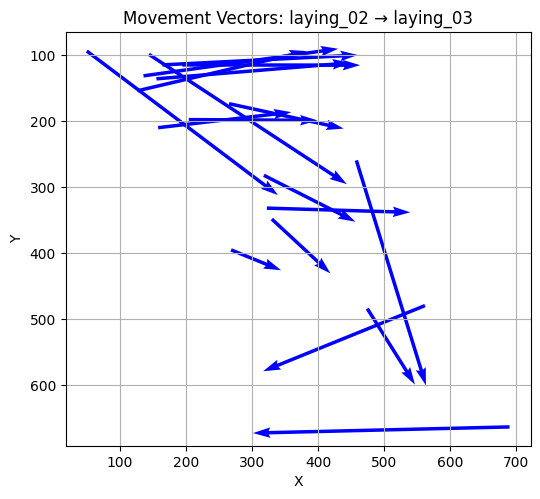

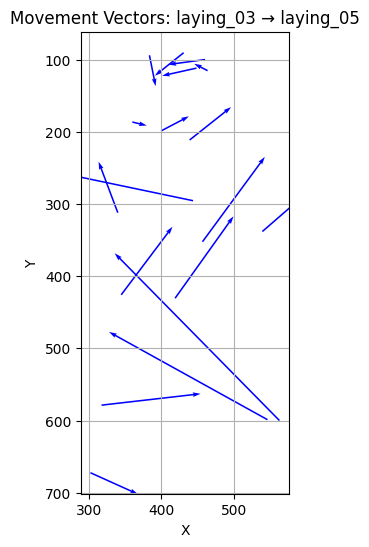

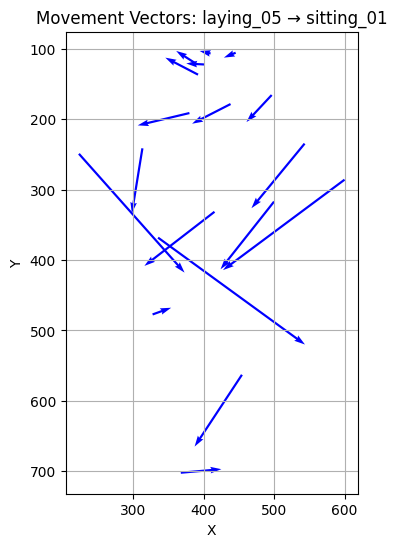

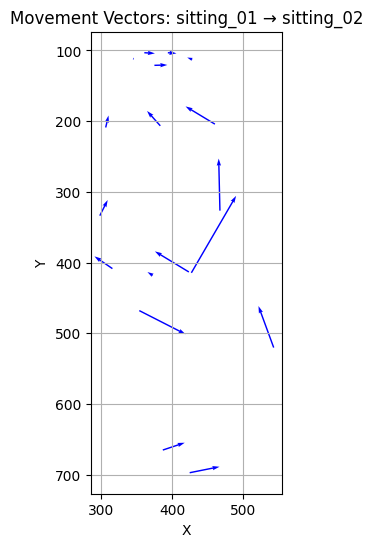

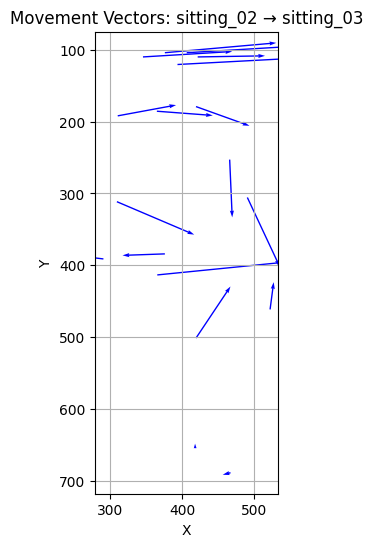

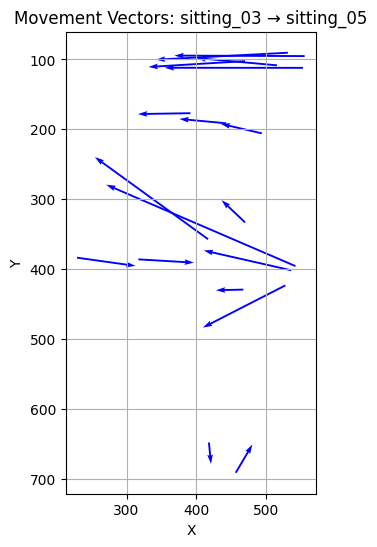

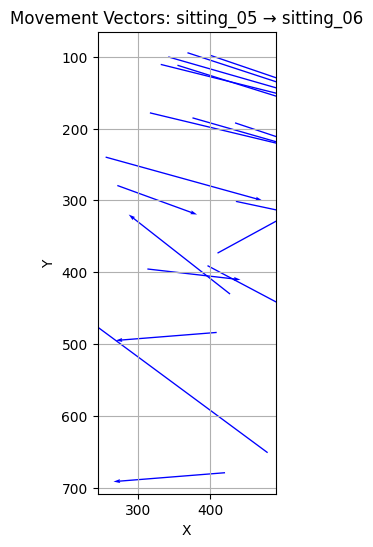

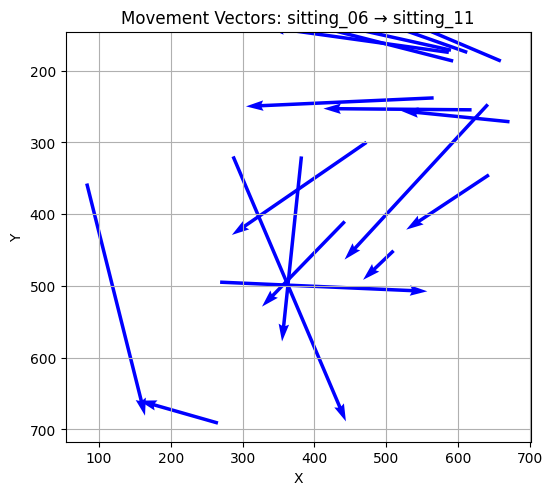

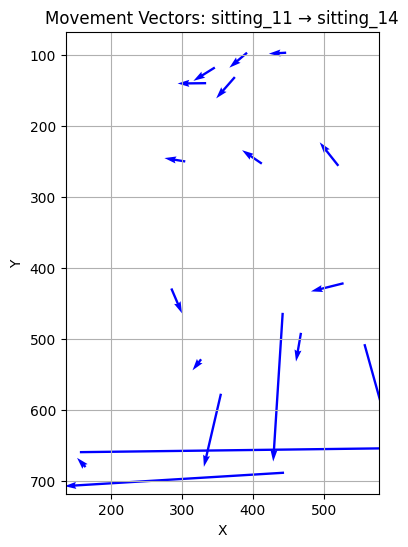

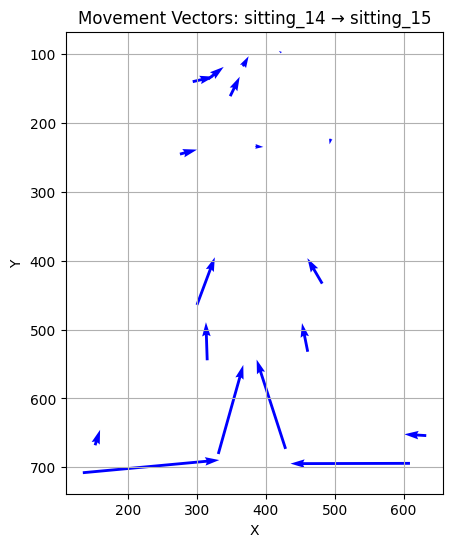

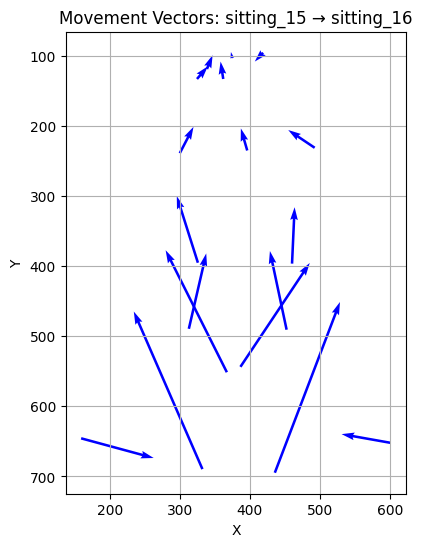

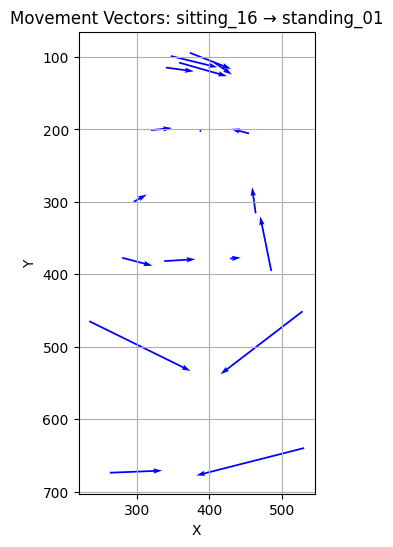

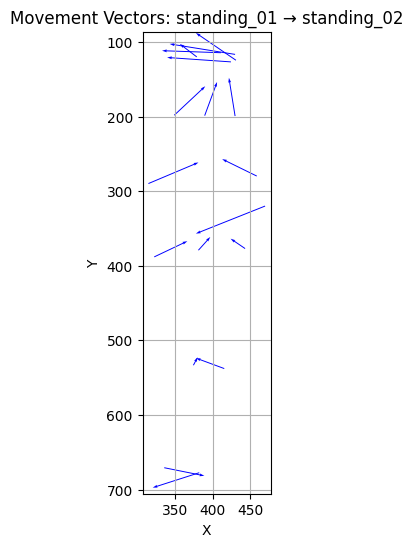

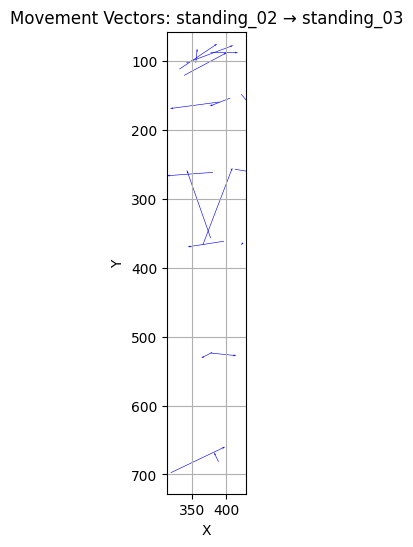

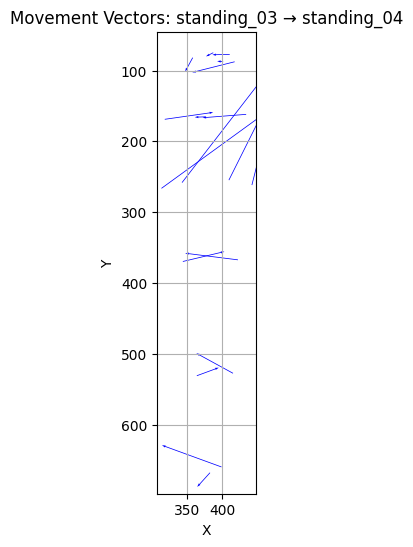

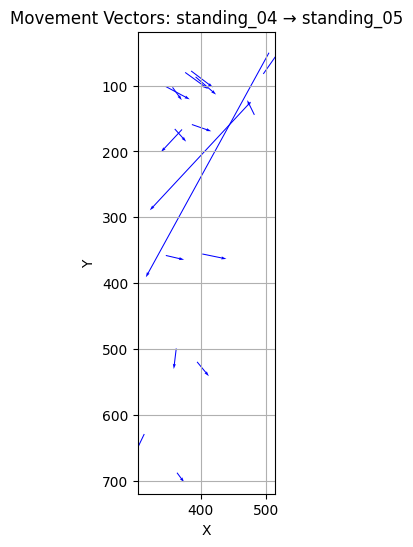

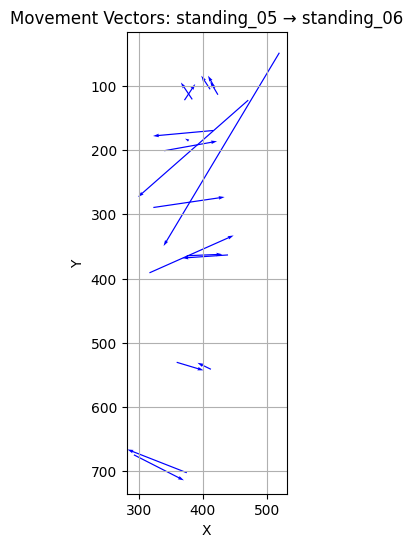

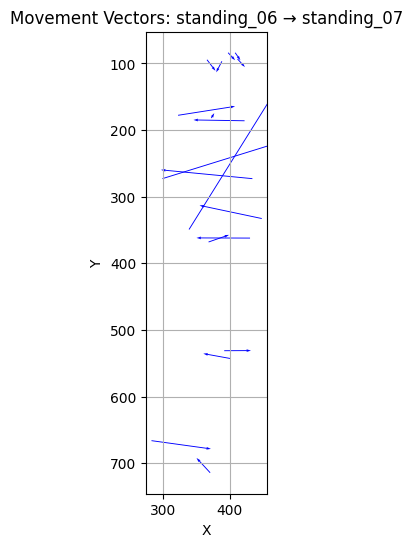

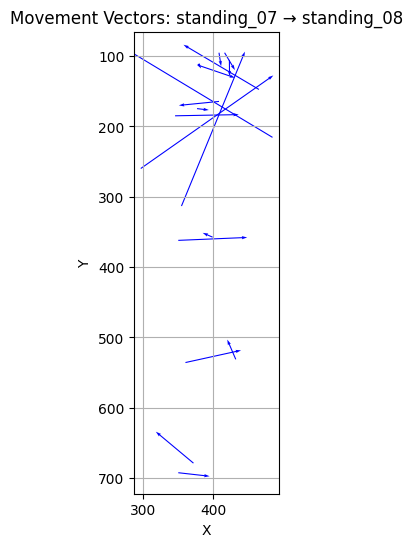

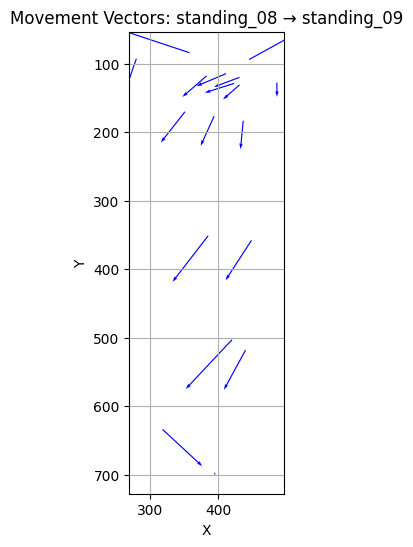

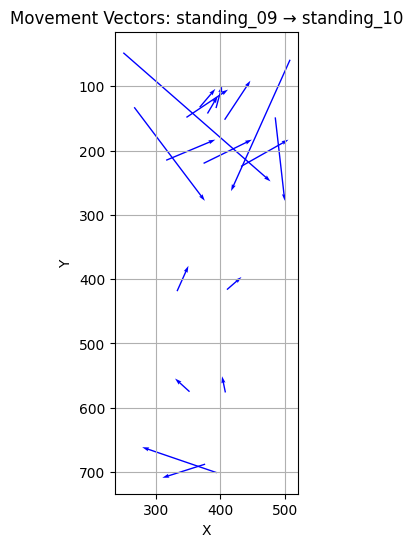

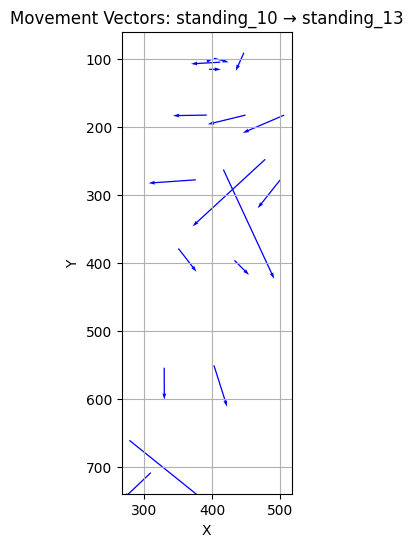

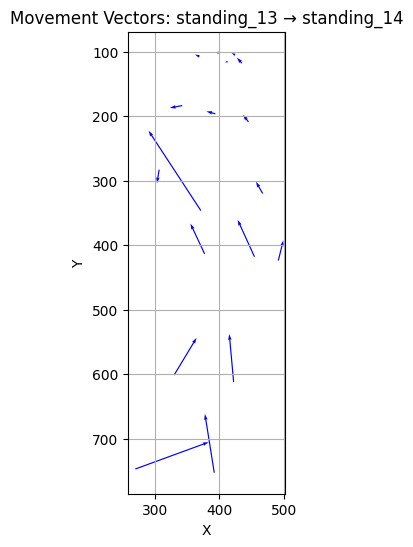

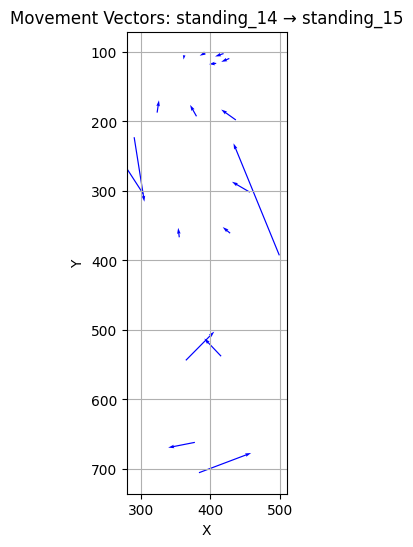

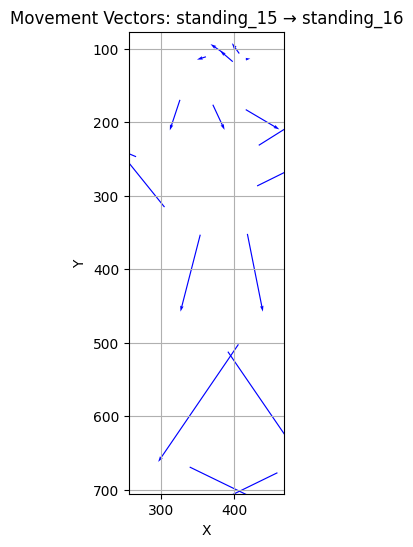

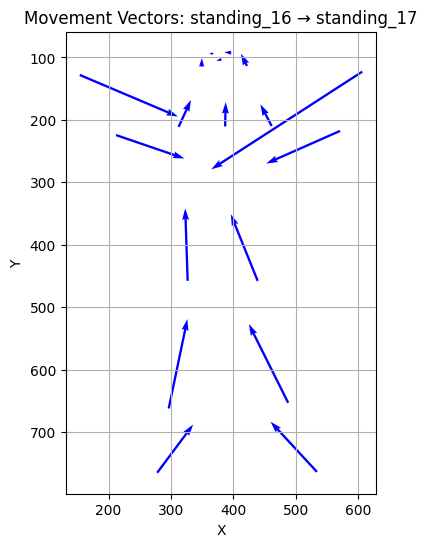

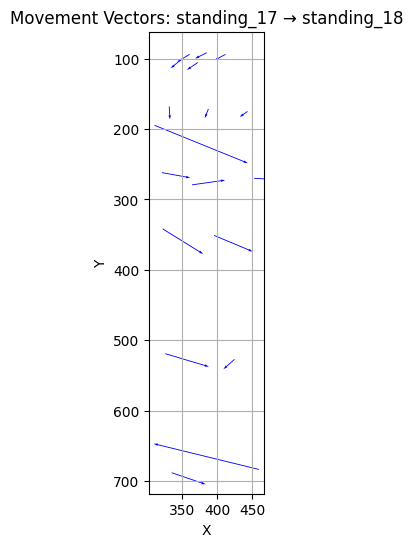

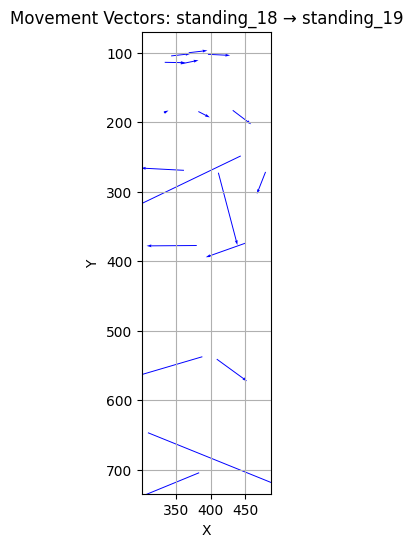

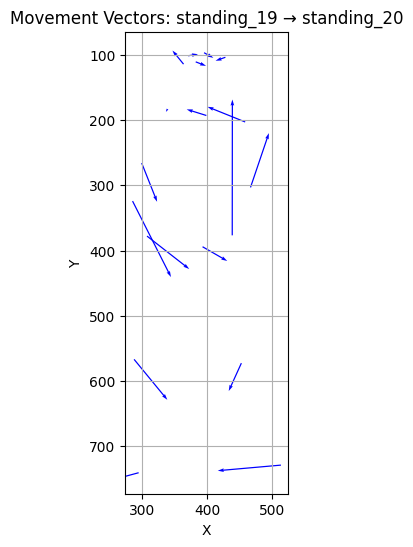

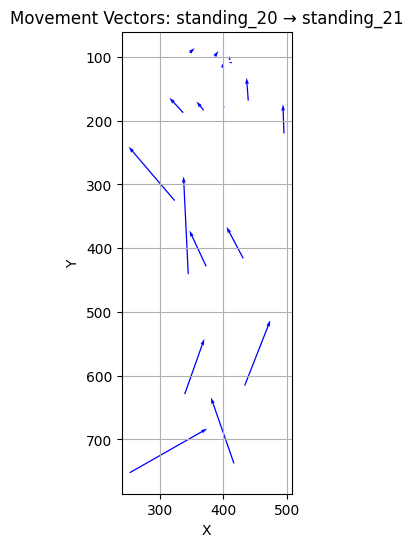

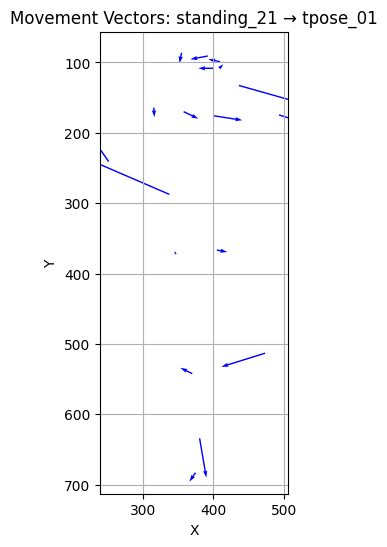

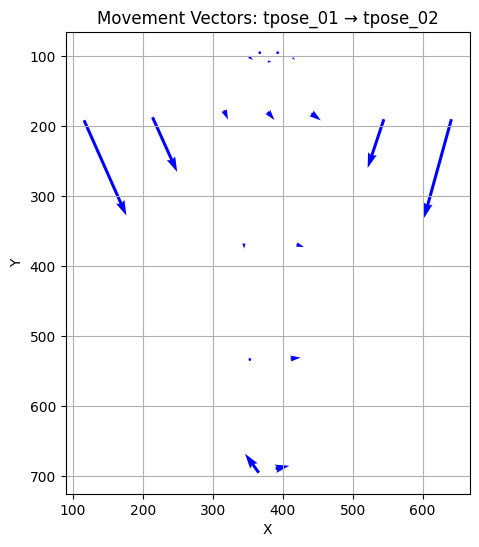

In [15]:
def loop_through_poses(df, vectors, pose_names):
    for i in range(len(vectors)):
        pose = df.iloc[i].values
        movement = vectors.iloc[i].values
        generate_vector_graph(pose, movement, pose_names[i], pose_names[i + 1])

loop_through_poses(df, vectors, pose_names)

## Step 3.5: Create TP02 Derived Features — Individual Move Vectors
Our TP01 function for deriving movement vectors batch processed our entire pose set, however we need to be able to compute between specific poses in order to generate training/testing data. So, we have new helper functions for that.

pose_to_df
* Takes in the name of a pose
* Loads the JSON file that matches the pose name (or returns an exception)
* Extracts the coordinates from the JSON file
* Strips out the Z-axis values (which are unused in 2D analysis)
* Outputs the pose as a DataFrame of x,y coordinates

poses_to_vectors
* Takes in 2 DataFrames, representing 2 different poses
* Tests DataFrames to ensure they have the same labels and are thus comparable
* Calculates movement vectors based on translation along individual axes for each axis provided
* Temporarily stores those vectors as a list
* Outputs the full list as a DataFrame of x,y movement vectors with a move name

pose_list_to_vector_df
* Takes a list of starting poses, 1 end pose DataFrame, a move name, and the column labels
* Calculates movement vectors based on the translation between each starting pose and the end pose
* Stores those vectors in a DataFrame, then returns that.


In [16]:
def pose_to_df(pose:str, labels, path="poses"):
    item = path + "/" + pose
    with open(item) as file:
        data = json.load(file)
        points_list = list(data[0]["people"][0]["pose_keypoints_2d"])   # Hardcoded to fit the JSON scheme
        unneeded_3d_coord = 1.0   # the JSONs provide z-axis data, which we don't need, and it's all 1.0
        points_list = [i for i in points_list if i != unneeded_3d_coord]

        # Prep and return payload DF
        df = DataFrame(columns=labels)
        df.loc[len(df)] = points_list
        return df


In [17]:
def poses_to_vectors(pose1:DataFrame, pose2:DataFrame, move_name:str):
    # Check to make sure these DFs are compatible
    p1_labels = pose1.columns
    p2_labels = pose2.columns
    if len(p1_labels) != len(p2_labels):
        print("DataFrame labels do not match. Halting.")
        return None
    
    # Prep a return DF and a temporary list for storing 1D vectors
    vects = prep_dataframe(labels=p1_labels)
    movement = []

    # Get joint x,y coords
    p1_coords = pose1.iloc[0].values.tolist()
    p2_coords = pose2.iloc[0].values.tolist()

    # Calculate movement vectors as 1D vectors and store them
    for i in range(len(p1_coords)):
        movement.append(p2_coords[i] - p1_coords[i])

    # Store movement vectors in DF, add name column, and return it
    vects.loc[len(vects)] = movement
    vects["move_name"] = move_name
    vects.reset_index(drop=True, inplace=True)
    return vects

In [26]:
def pose_list_to_vector_df(starting_poses:list, end_pose:DataFrame, move_name:str, labels):
    move_vects = DataFrame(columns=labels,dtype="float64")
    move_vects["move_name"] = ""
    move_vects.reset_index(drop=True, inplace=True)
    for i in range(len(starting_poses)):
        start_df = pose_to_df(starting_poses[i],labels=labels)  # Read pose from JSON
        move_df = poses_to_vectors(start_df, end_pose, move_name=move_name) # Calculate movement vector
        move_vects = pd.concat([move_vects, move_df], axis=0,ignore_index=True)
        #move_vects.loc[len(move_vects)] = move_df    # store movement vector
    return move_vects

# Step 4: Generate labeled dance move set
In order to use any classification AI, we need training and testing data. In this case, we've selected 4 dance moves that the classifiers should have good luck with:
* Kick
* Yay (hands up)
* Hands left
* Hands right
Moves are defined by the sets of movement vectors that results when transitioning from one pose to another.

## Step 4.1: Generate Labeled Move Data Set

### Step 4.1.1: Generate Labeled Move Data — Kick

In [27]:
kick_pose = pose_to_df("dance_03.json",labels=labels)
kick_start_frames = ["dance_02.json",   # Hand-selected poses that can work as starting poses
                     "dance_05.json",
                     "flexing_01.json",
                     "flexing_02.json",
                     "flexing_03.json",
                     "standing_01.json",
                     "standing_02.json",
                     "standing_03.json",
                     "standing_04.json",
                     "standing_05.json",
                     "standing_06.json",
                     "standing_07.json",
                     "standing_08.json",
                     "standing_09.json",
                     "standing_10.json",
                     "standing_13.json",
                     "standing_14.json",
                     "standing_15.json",
                     "standing_18.json",
                     "standing_19.json",
                     "standing_20.json",
                     "standing_21.json",
                     "tpose_01.json",
                     "tpose_02.json"]
kick_df = pose_list_to_vector_df(kick_start_frames,kick_pose,"Kick",labels=labels)
display(kick_df)

,00x,00y,01x,01y,02x,02y,03x,03y,04x,04y,...,13y,14x,14y,15x,15y,16x,16y,17x,17y,move_name
0,-72.590914,20.248485,-90.433520,16.486570,-79.069510,15.854649,-97.812728,-74.868351,40.396044,-26.894524,...,-234.263467,-70.946224,18.063563,-69.142150,25.837040,-75.735000,20.476993,-84.034617,34.798189,Kick
1,-73.158232,-46.686361,-42.717950,-27.506209,-34.520793,-32.806970,-65.298043,-48.827517,42.337059,-7.275864,...,-219.207045,-70.526291,-46.582104,-66.162596,-45.318262,-50.579463,-44.931733,-53.041013,-44.931733,Kick
2,-96.164345,-24.520807,-100.299125,-27.773966,-106.862830,-18.128728,-140.372931,-23.074928,-110.513959,8.427440,...,-237.553094,-97.802669,-29.768621,-92.898107,-24.177554,-105.214096,-29.940247,-104.231049,-25.613023,Kick
3,-45.150659,22.021939,-76.055945,14.826489,-67.170682,8.933250,-90.794821,-56.123923,-26.372125,-13.270983,...,-241.363727,-47.171784,17.473129,-40.507188,23.413698,-59.904867,16.777249,-60.132555,27.299885,Kick
4,-79.835885,27.357480,-76.117294,9.325793,-71.647694,2.425944,-75.865443,-54.446956,-31.571704,-9.045507,...,-248.540738,-79.814233,21.432578,-77.205634,26.115290,-81.180641,14.076310,-81.040466,18.634803,Kick
5,-126.339821,6.405836,-82.293799,-5.636063,-94.588881,-5.709267,-172.430428,-154.211642,-100.630396,-289.197136,...,-220.944835,-124.305210,4.795330,-116.760878,3.824307,-105.801929,5.527378,-98.920677,1.057648,Kick
6,-40.775917,12.325783,-98.924205,39.428452,-136.108416,33.118973,-239.506281,-125.949971,-145.002335,-268.122661,...,-240.970501,-45.337427,7.507611,-29.016345,17.855546,-83.085435,22.910915,-45.259571,37.672566,Kick
7,-102.820019,45.453050,-69.014296,27.706885,-64.632323,23.592337,-172.470778,-130.794120,-188.040524,-155.836788,...,-203.315051,-100.264090,44.320418,-96.940917,43.262509,-85.144463,43.674375,-84.948538,37.869996,Kick
8,-94.419032,46.292621,-53.926755,27.211674,-133.002549,33.360906,-340.420649,-8.819495,-274.360896,16.689650,...,-172.656017,-89.970921,39.171510,-72.471772,42.695737,-74.488189,24.017070,-25.259334,22.886878,Kick
9,-125.483007,19.463401,-71.187158,7.989552,-162.445652,23.113269,-329.466354,13.507280,-298.323178,50.786154,...,-218.136072,-124.737866,14.044941,-105.469012,17.732727,-110.764772,4.608515,-39.244467,3.396543,Kick


### Step 4.1.2: Generate Labeled Move Data — Yay

In [29]:
# We have 3 poses that work as the Yay end frame
yay_pose1 = pose_to_df("standing_08.json",labels=labels)
yay_pose2 = pose_to_df("standing_09.json",labels=labels)
yay_pose3 = pose_to_df("standing_16.json",labels=labels)
yay_start_frames = ["dance_02.json",   # Hand-selected poses that can work as starting poses
                     "dance_05.json",
                     "flexing_01.json",
                     "flexing_02.json",
                     "flexing_03.json",
                     "standing_01.json",
                     "standing_02.json",
                     "standing_03.json",
                     "standing_04.json",
                     "standing_05.json",
                     "standing_06.json",
                     "standing_07.json",
                     "standing_10.json",
                     "standing_13.json",
                     "standing_14.json",
                     "standing_15.json",
                     "standing_18.json",
                     "standing_19.json",
                     "standing_20.json",
                     "standing_21.json",
                     "tpose_01.json",
                     "tpose_02.json"]

yay_df1 = pose_list_to_vector_df(yay_start_frames,yay_pose1,"Yay",labels=labels)
yay_df2 = pose_list_to_vector_df(yay_start_frames,yay_pose2,"Yay",labels=labels)
yay_df3 = pose_list_to_vector_df(yay_start_frames,yay_pose3,"Yay",labels=labels)

### Step 4.1.3: Generate Labeled Move Data — Hands_Left

In [30]:
hands_left_pose = pose_to_df("dance_04.json",labels=labels)
# We can reuse kick_start_frames for this one
hands_left_df = pose_list_to_vector_df(kick_start_frames,hands_left_pose,"Hands_Left",labels=labels)

### Step 4.1.4 Generate Labeled Move Data — Hands Right
Pose dance_04 is the end pose for the Hands Left dance move. We do not have an end pose for the Hands Right dance move, but we can create such a pose with a few value swaps.

In [ ]:
# First, make a DF for each pose that we need to use 
hands_left = prep_dataframe(labels=labels)
hands_right = prep_dataframe(labels=labels)

#hands_left = store_pose()



### Step 4.1.9 Concatenate Labeled Move Data

In [31]:
move_df = pd.concat([kick_df, yay_df1, yay_df2, yay_df3, hands_left_df], axis=0,ignore_index=True)
display(move_df)

,00x,00y,01x,01y,02x,02y,03x,03y,04x,04y,...,13y,14x,14y,15x,15y,16x,16y,17x,17y,move_name
0,-72.590914,20.248485,-90.433520,16.486570,-79.069510,15.854649,-97.812728,-74.868351,40.396044,-26.894524,...,-234.263467,-70.946224,18.063563,-69.142150,25.837040,-75.735000,20.476993,-84.034617,34.798189,Kick
1,-73.158232,-46.686361,-42.717950,-27.506209,-34.520793,-32.806970,-65.298043,-48.827517,42.337059,-7.275864,...,-219.207045,-70.526291,-46.582104,-66.162596,-45.318262,-50.579463,-44.931733,-53.041013,-44.931733,Kick
2,-96.164345,-24.520807,-100.299125,-27.773966,-106.862830,-18.128728,-140.372931,-23.074928,-110.513959,8.427440,...,-237.553094,-97.802669,-29.768621,-92.898107,-24.177554,-105.214096,-29.940247,-104.231049,-25.613023,Kick
3,-45.150659,22.021939,-76.055945,14.826489,-67.170682,8.933250,-90.794821,-56.123923,-26.372125,-13.270983,...,-241.363727,-47.171784,17.473129,-40.507188,23.413698,-59.904867,16.777249,-60.132555,27.299885,Kick
4,-79.835885,27.357480,-76.117294,9.325793,-71.647694,2.425944,-75.865443,-54.446956,-31.571704,-9.045507,...,-248.540738,-79.814233,21.432578,-77.205634,26.115290,-81.180641,14.076310,-81.040466,18.634803,Kick
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,18.691332,2.442275,11.069699,-22.313028,22.368009,-10.655324,-26.231448,-57.478781,-130.689998,-111.160969,...,-42.125616,16.420708,0.161238,17.472715,-0.979280,14.129258,-9.186792,15.004241,-12.623967,Hands_Left
110,2.833367,-3.743945,41.230960,-12.914235,24.963226,-15.093210,-49.855576,-116.886369,-189.598125,-227.630170,...,-50.676582,1.220346,2.567141,3.243981,-8.841000,31.139503,11.652591,30.078095,-17.967512,Hands_Left
111,1.177789,4.976949,52.356083,0.797350,46.628483,8.356930,22.359471,-32.433211,-182.197623,-74.328333,...,52.773591,-4.613760,10.816190,3.483136,-3.135122,23.327883,18.954274,34.841613,-17.088601,Hands_Left
112,22.762851,4.971935,31.472937,-9.202205,45.714180,-5.331652,59.621697,20.736868,39.077179,21.125176,...,-3.123542,20.178905,6.129702,20.186060,0.322978,26.497410,3.937641,29.095666,-11.417520,Hands_Left
